In [16]:
import ivy

# Write Ivy Code

## Data Structures

In [2]:
%%capture
ivy.set_backend("torch")

In [3]:
x = ivy.array([1, 2, 3])
print(type(x))

<class 'ivy.data_classes.array.array.Array'>


In [4]:
x = ivy.native_array([1, 2, 3])
print(type(x))

<class 'torch.Tensor'>


## Ivy Functional API

In [10]:
ivy.set_backend("jax")
x1, x2 = ivy.array([[1], [2], [3]]), ivy.array([[1, 2, 3]])
output = ivy.matmul(x1, x2)
print(type(output.to_native()))

<class 'jaxlib.xla_extension.ArrayImpl'>


In [11]:
ivy.set_backend("tensorflow")
x1, x2 = ivy.array([[1], [2], [3]]), ivy.array([[1, 2, 3]])
output = ivy.matmul(x1, x2)
print(type(output.to_native()))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [12]:
ivy.set_backend("torch")
x1, x2 = ivy.array([[1], [2], [3]]), ivy.array([[1, 2, 3]])
output = ivy.matmul(x1, x2)
print(type(output.to_native()))

<class 'torch.Tensor'>


In [13]:
ivy.set_backend("numpy")
x1, x2 = ivy.array([[1], [2], [3]]), ivy.array([[1, 2, 3]])
output = ivy.matmul(x1, x2)
print(type(output.to_native()))

<class 'numpy.ndarray'>


In [15]:
ivy.set_array_mode(False)

ivy.set_backend("jax")
x1, x2 = ivy.native_array([[1], [2], [3]]), ivy.native_array([[1, 2, 3]])
output = ivy.matmul(x1, x2)
print(type(output))

ivy.set_backend("tensorflow")
x1, x2 = ivy.native_array([[1], [2], [3]]), ivy.native_array([[1, 2, 3]])
output = ivy.matmul(x1, x2)
print(type(output))

ivy.set_backend("torch")
x1, x2 = ivy.native_array([[1], [2], [3]]), ivy.native_array([[1, 2, 3]])
output = ivy.matmul(x1, x2)
print(type(output))

ivy.set_array_mode(True)

<class 'jaxlib.xla_extension.ArrayImpl'>
<class 'ivy.data_classes.array.array.Array'>
<class 'torch.Tensor'>


# Unify Code

In [1]:
import ivy
import torch

In [8]:
def normalize(x):
    mean = torch.mean(x)
    std = torch.std(x)
    return torch.div(torch.sub(x, mean), std)

In [9]:
normalize = ivy.unify(normalize, source="torch")

In [10]:
# import the frameworks
import numpy as np
import jax.numpy as jnp
import tensorflow as tf

In [11]:
x = np.random.uniform(size=10).astype(np.float32)
ivy.set_backend("numpy")
print(normalize(x))

TypeError: mean(): argument 'input' (position 1) must be Tensor, not NewNDArray

In [14]:
# jax
x_ = jnp.array(x)
ivy.set_backend("jax")
print(normalize(x_))

ivy.array([ 0.97889817, -0.31358162, -0.1838607 ,  0.68678105,  0.4830147 ,
       -1.90820944,  1.37414706, -1.01904213, -0.6111415 ,  0.51299494])


In [16]:
# tensorflow
x_ = tf.constant(x)
ivy.set_backend("tensorflow")
print(normalize(x_))

ivy.array([ 0.97889823, -0.31358165, -0.18386073,  0.68678117,  0.48301476,
       -1.90820968,  1.3741473 , -1.01904213, -0.61114156,  0.512995  ])


In [17]:
# torch
x_ = torch.tensor(x)
ivy.set_backend("torch")
print(normalize(x_))

ivy.array([ 0.97889805, -0.31358185, -0.18386094,  0.68678093,  0.48301455,
       -1.9082098 ,  1.37414706, -1.01904237, -0.6111418 ,  0.51299483])


# Trace Code

In [18]:
import ivy
import torch

def normalize(x):
    mean = torch.mean(x)
    std = torch.std(x)
    return torch.div(torch.sub(x, mean), std)
    
normalize = ivy.unify(normalize, source="torch")

In [19]:
ivy.set_backend("jax")

import jax

key = jax.random.PRNGKey(42)
x = jax.random.uniform(key, shape=(10,))

In [20]:
normalize(x)

ivy.array([ 0.55563939, -0.65538698, -1.14150512,  1.46951973,  1.30220282,
       -1.14739656, -0.5701794 , -0.91962665,  0.51028997,  0.59644389])

In [21]:
ivy.set_backend("jax")
traced = ivy.trace_graph(normalize)

In [22]:
traced(x)

Array([ 0.5556394 , -0.655387  , -1.1415051 ,  1.4695197 ,  1.3022028 ,
       -1.1473966 , -0.5701794 , -0.91962665,  0.51028997,  0.5964439 ],      dtype=float32)

In [25]:
%%timeit
normalize(x)

24.6 ms ± 3.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
%%timeit
traced(x)

695 µs ± 3.67 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Transpile Code

In [27]:
import ivy
import torch
ivy.set_backend("jax")

def normalize(x):
    mean = torch.mean(x)
    std = torch.std(x)
    return torch.div(torch.sub(x, mean), std)

# convert the function to Ivy code
ivy_normalize = ivy.unify(normalize)

# trace the Ivy code into jax functions
jax_normalize = ivy.trace_graph(ivy_normalize)

In [29]:
jax_normalize = ivy.transpile(normalize, source="torch", to="jax")

In [30]:
import jax

key = jax.random.PRNGKey(42)
jax.config.update("jax_enable_x64", True)
x = jax.random.uniform(key, shape=(10,))

print(jax_normalize(x))

[-0.93968587  0.26075466 -0.22723222 -1.06276492 -0.47426987  1.72835908
  1.71737559 -0.50411096 -0.65419174  0.15576624]


# Lazy vs Eager

In [31]:
import ivy
import torch

def normalize(x):
    mean = torch.mean(x)
    std = torch.std(x)
    return torch.div(torch.sub(x, mean), std)

In [32]:
# import NumPy
import numpy as np
np.random.seed(0)

# create random numpy array for testing
x = np.random.uniform(size=10)

In [33]:
import tensorflow as tf
ivy.set_backend("tensorflow")

x = tf.constant(x)

In [34]:
norm = ivy.unify(normalize, source="torch")
norm(x) # slow, lazy unification
norm(x) # fast, unified on previous call

2023-12-19 18:37:02.945222: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-12-19 18:37:03.013400: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


ivy.array([-0.34431235,  0.51129461, -0.06686894, -0.36452447, -0.98795534,
        0.15493582, -0.91630631,  1.41939619,  1.78909753, -1.19475674])

In [35]:
ivy.set_backend("tensorflow")
norm = ivy.unify(normalize, source="torch", args=(x,))
norm(x) # fast, unified at ivy.unify
norm(x) # fast, unified at ivy.unify

ivy.array([-0.34431235,  0.51129461, -0.06686894, -0.36452447, -0.98795534,
        0.15493582, -0.91630631,  1.41939619,  1.78909753, -1.19475674])

In [36]:
norm_trace = ivy.trace_graph(norm)
norm_trace(x) # slow, lazy graph tracing
norm_trace(x) # fast, traced on previous call

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([-0.34431235,  0.51129461, -0.06686894, -0.36452447, -0.98795534,
        0.15493582, -0.91630631,  1.41939619,  1.78909753, -1.19475674])>

In [37]:
norm_tracing = ivy.trace_graph(norm, args=(x,))
norm_tracing(x) # fast, traced at ivy.trace_graph
norm_tracing(x) # fast, traced at ivy.trace_graph

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([-0.34431235,  0.51129461, -0.06686894, -0.36452447, -0.98795534,
        0.15493582, -0.91630631,  1.41939619,  1.78909753, -1.19475674])>

In [38]:
norm_trans = ivy.transpile(normalize, source="torch", to="tensorflow")
norm_trans(x) # slow, lazy transpilation
norm_trans(x) # fast, transpiled on previous call

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([-0.34431235,  0.51129461, -0.06686894, -0.36452447, -0.98795534,
        0.15493582, -0.91630631,  1.41939619,  1.78909753, -1.19475674])>

In [39]:
norm_trans = ivy.transpile(normalize, source="torch", to="tensorflow", args=(x,))
norm_trans(x) # fast, transpiled at ivy.transpile
norm_trans(x) # fast, transpiled at ivy.transpile

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([-0.34431235,  0.51129461, -0.06686894, -0.36452447, -0.98795534,
        0.15493582, -0.91630631,  1.41939619,  1.78909753, -1.19475674])>

# How to use decorators

In [40]:
# import numpy
import numpy as np
np.random.seed(0)

# create random numpy arrays for testing
x = np.random.uniform(size=10)
mean = np.mean(x)
std = np.std(x)

In [41]:
import ivy
import tensorflow as tf
ivy.set_backend("tensorflow")

x = tf.constant(x)

## Unify

In [42]:
import torch

@ivy.unify(source="torch")
def normalize(x):
    mean = torch.mean(x)
    std = torch.std(x)
    return torch.div(torch.sub(x, mean), std)

In [43]:
normalize(x) # unification happens here

ivy.array([-0.34431235,  0.51129461, -0.06686894, -0.36452447, -0.98795534,
        0.15493582, -0.91630631,  1.41939619,  1.78909753, -1.19475674])

In [44]:
@ivy.unify(source="torch", args=(x,))
def normalize(x):
    mean = torch.mean(x)
    std = torch.std(x)
    return torch.div(torch.sub(x, mean), std)

In [46]:
normalize(x) # already unified

ivy.array([-0.34431235,  0.51129461, -0.06686894, -0.36452447, -0.98795534,
        0.15493582, -0.91630631,  1.41939619,  1.78909753, -1.19475674])

## Trace

In [47]:
@ivy.trace_graph
def normalize(x):
    mean = ivy.mean(x)
    std = ivy.std(x, correction=1)
    return ivy.divide(ivy.subtract(x, mean), std)

In [48]:
normalize(x) # tracing happens here

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([-0.34431235,  0.51129461, -0.06686894, -0.36452447, -0.98795534,
        0.15493582, -0.91630631,  1.41939619,  1.78909753, -1.19475674])>

In [49]:
@ivy.trace_graph(args=(x,))
def normalize(x):
    mean = ivy.mean(x)
    std = ivy.std(x, correction=1)
    return ivy.divide(ivy.subtract(x, mean), std)

In [50]:
normalize(x) # already traced

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([-0.34431235,  0.51129461, -0.06686894, -0.36452447, -0.98795534,
        0.15493582, -0.91630631,  1.41939619,  1.78909753, -1.19475674])>

## Transpile

In [51]:
@ivy.transpile(source="torch", to="tensorflow")
def normalize(x):
    mean = torch.mean(x)
    std = torch.std(x)
    return torch.div(torch.sub(x, mean), std)

In [52]:
normalize(x) # transpilation happens here

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([-0.34431235,  0.51129461, -0.06686894, -0.36452447, -0.98795534,
        0.15493582, -0.91630631,  1.41939619,  1.78909753, -1.19475674])>

In [53]:
@ivy.transpile(source="torch", to="tensorflow", args=(x,))
def normalize(x):
    mean = torch.mean(x)
    std = torch.std(x)
    return torch.div(torch.sub(x, mean), std)

In [54]:
normalize(x) # already transpiled

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([-0.34431235,  0.51129461, -0.06686894, -0.36452447, -0.98795534,
        0.15493582, -0.91630631,  1.41939619,  1.78909753, -1.19475674])>

# Transpile any library

In [56]:
import ivy
import kornia
import requests
import jax
import jax.numpy as jnp
import numpy as np
from PIL import Image

In [57]:
jax.config.update("jax_enable_x64", True)
jax_kornia = ivy.transpile(kornia, source="torch", to="jax")

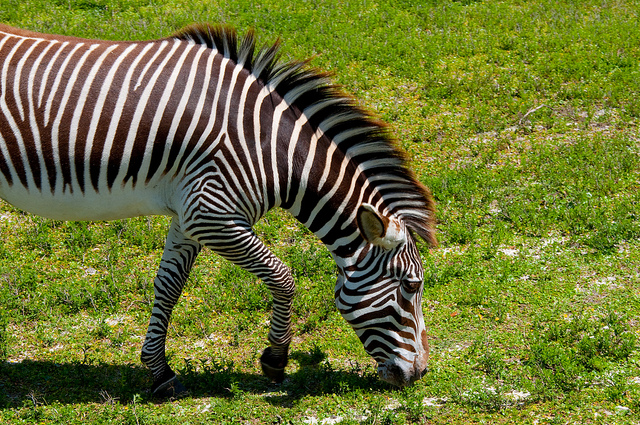

In [58]:
url = "http://images.cocodataset.org/train2017/000000000034.jpg"
raw_img = Image.open(requests.get(url, stream=True).raw)
img = jnp.transpose(jnp.array(raw_img), (2, 0, 1))
img = jnp.expand_dims(img, 0) / 255
display(raw_img)

In [62]:
out = jax_kornia.enhance.sharpness(img, 10)
type(out)

IvyBackendException: jax: clip: where() got some positional-only arguments passed as keyword arguments: 'acondition, if_true, if_false'

In [61]:
np_image = np.uint8(np.array(out[0])*255)
display(Image.fromarray(np.transpose(np_image, (1, 2, 0))))

NameError: name 'out' is not defined

# Transpile any model

In [1]:
import ivy
import torch
import numpy as np
import tensorflow as tf
tf.keras.utils.set_random_seed(0)
torch.manual_seed(0)

2023-12-19 19:11:46.611032: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-19 19:11:46.662496: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 19:11:46.662534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 19:11:46.664805: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 19:11:46.674866: I tensorflow/core/platform/cpu_feature_guar

In [2]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

2023-12-19 19:11:49.462094: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-19 19:11:49.603287: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-19 19:11:49.603393: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-19 19:11:49.611344: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-19 19:11:49.611444: I external/local_xla/xla/stream_executor

In [3]:
input_array = tf.random.normal((1, 28, 28, 3))
torch_model = ivy.transpile(model, source = "tensorflow", to="torch", args=(input_array,))

/home/dwalker/mambaforge/envs/olympic/lib/python3.10/site-packages/ivy/utils/exceptions.py:390: UserWarning: The current backend: 'tensorflow' does not support inplace updates natively. Ivy would quietly create new arrays when using inplace updates with this backend, leading to memory overhead (same applies for views). If you want to control your memory management, consider doing ivy.set_inplace_mode('strict') which should raise an error whenever an inplace update is attempted with this backend.
  warnings.warn(
/home/dwalker/mambaforge/envs/olympic/lib/python3.10/site-packages/ivy/compiler/compiler.py:159: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return _transpile(
/home/dwalker/mambaforge/envs/olympic/lib/python3.10/site-packages/ivy/compiler/compiler.py:159: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in T

UnimplementedError: Exception encountered when calling layer 'conv2d' (type Conv2D).

{{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} DNN library is not found. [Op:Conv2D] name: 

Call arguments received by layer 'conv2d' (type Conv2D):
  • inputs=tf.Tensor(shape=(1, 28, 28, 3), dtype=float32)

In [4]:
isinstance(torch_model, torch.nn.Module)

NameError: name 'torch_model' is not defined

In [5]:
input_array = torch.rand((1, 28, 28, 3))
output_array = torch_model(input_array)
print(output_array)

NameError: name 'torch_model' is not defined